# Multi-modal Fine-tuning - Qwen VL Models

Built by [Trelis.com](https://Trelis.com). Find us on [HuggingFace](https://huggingface.co/Trelis) and [GitHub](https://github.com/TrelisResearch).

This is a private notebook - available for purchase from Trelis.com .

---

## Qwen Specific Notes:
- For gradient checkpointing, setting use_reentrant to True gives issues of there being no gradients set.
- qkv in the vision tower cannot be trained without issues, possibly as qkv is fused (?).
- oddly, LoRA weights on the language model are set to 32 bit by default, and have to be manually set then to 16 bits.
- in formatting the data, it's critical not to mask the end of sequence token at the end of assistant responses.

---

Inspired by a base notebook available from HuggingFace [here](https://colab.research.google.com/drive/1rm3AGquGEYXfeeizE40bbDtcWh5S4Nlq?usp=sharing). With credit due to:
- [IDEFICS 2 blog](https://huggingface.co/blog/idefics2)
- *Hugo Laurençon and Lucile Saulnier and Léo Tronchon and Stas Bekman and Amanpreet Singh and Anton Lozhkov and Thomas Wang and Siddharth Karamcheti and Alexander M. Rush and Douwe Kiela and Matthieu Cord and Victor Sanh*

Other Qwen VL guide from hf:
- [here](https://huggingface.co/learn/cookbook/fine_tuning_vlm_trl)

---

## Getting Set Up
### Setup on an Ampere GPU (A40, A6000, A100, H100) with Cuda 12.1 and Pytorch 2.2.1 - RECOMMENDED.
Ampere architecture GPUs allow for the use of Flash Attention, which provides a speed up. Otherwise, you need to train with fp16 instead of bf16.

For the best reproducibility, run this script on an A40:
- Runpod one-click template [here](https://runpod.io/gsc?template=ifyqsvjlzj&ref=jmfkcdio) - easier setup.
- Vast.ai one-click template [here](https://cloud.vast.ai/?ref_id=98762&creator_id=98762&name=Fine-tuning%20Notebook%20by%20Trelis%20-%20Cuda%2012.1) - offers smaller GPUs (which are cheaper to run).

### GPU requirements for training

- On an A100 (80 GB) you can train on batch size one for Qwen 2B or 7B - probably this will also work on an A40 with 48 GB. For Qwen 72B, my guess is that you'll need 2x A100 or 6xA40.
- On a colab T4 you have to use quantization to fit the two smaller models in 15 GB (and even that may be tight, I haven't tested).

# Setup

We first setup the environment with the primary necessary libraries and login into Hugging Face.

In [1]:
!python -m pip install --upgrade pip -q
!pip install -q transformers qwen-vl-utils
!pip install -q accelerate datasets peft bitsandbytes hf_transfer flash_attn tensorboard

# Can be a good idea to re-start the kernel after this

In [2]:
# !pip freeze > requirements.txt

In [6]:
from huggingface_hub import notebook_login

notebook_login()

# Loading the model and the dataset

We load the model from the Hugging Face hub. `idefics2-8b` has gone through instruction fine-tuning on a large mixture of multimodal datasets and as such is a strong starting-point to fine-tune on your own use-case. We will start from this checkpoint.

Fine-tuning will be done on a small chess dataset.

In [1]:
# Enable fast weights download and upload
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" # if you're connected to multiple gpus but only want to use one.

In [10]:
# # If in colab (or just don't install flash attention above).
# !pip uninstall flash-attn -y

In [9]:
!pip install flash_attn==2.7.3 -q

In [2]:
# !pip uninstall transformers -y

Found existing installation: transformers 4.48.2
Uninstalling transformers-4.48.2:
  Successfully uninstalled transformers-4.48.2


In [3]:
!pip install git+https://github.com/huggingface/transformers accelerate -q

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-sbf_2_t6
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-sbf_2_t6
  Resolved https://github.com/huggingface/transformers to commit 62db3e6ed67a74cc1ed1436acd9973915c0a4475
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.49.0.dev0-py3-none-any.whl size=10627237 sha256=c468469ae955e11f829adaff3b2402d1a2d6aa1c4d14cf7f1aa6b700d64ac83a
  Stored in directory: /tmp/pip-ephem-wheel-cache-13g5o2a9/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers


In [31]:
import torch
from PIL import Image
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from transformers import BitsAndBytesConfig

# del model

DEVICE = 'cuda' # or 'mps' for mac

model_id = "Qwen/Qwen2.5-VL-3B-Instruct"
# model_id = "Qwen/Qwen2.5-VL-7B-Instruct"
# model_id = "Qwen/Qwen2.5-VL-72B-Instruct"

# Define the quantization configuration with NF4 and double quantization
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,             # Use 4-bit quantization (NF4)
    bnb_4bit_quant_type="nf4",     # Set quantization type to NF4
    bnb_4bit_use_double_quant=True # Enable double quantization
)

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16, #float16 for colab.
    attn_implementation="flash_attention_2" if DEVICE == 'cuda' else 'eager', # if not in colab.
    # attn_implementation='eager',
    device_map=DEVICE,
    # quantization_config=quant_config, # for colab 
)

processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
# # Iterate through all parameters and print their dtype
# for name, param in model.named_parameters():
#     print(f"Layer: {name}, dtype: {param.dtype}")

In [32]:
print(processor.tokenizer.model_max_length)
processor.tokenizer.model_max_length=4096*4 # or you'll run out of VRAM on larger models
print(processor.tokenizer.model_max_length)

131072
16384


In [4]:
from PIL import Image
from io import BytesIO
import requests

# Image URLs
IMG_URLS = [
    "https://picsum.photos/id/237/400/300", 
    "https://picsum.photos/id/231/200/300", 
    "https://picsum.photos/id/27/500/500",
    "https://picsum.photos/id/17/150/600",
]

# Function to load images from URLs
def load_images(urls):
    images = []
    for url in urls:
        response = requests.get(url, stream=True)
        img = Image.open(BytesIO(response.content))
        images.append(img)
    return images

# Load the images
images = load_images(IMG_URLS)

# Your prompt
PROMPT = "Describe the images, one by one in the following format:\n\nFirst image:\n\nSecond image:\n\nThird image:\n\nFourth image:\n\n"

messages = [
    {"role": "user", "content": [
        {"type": "text", "text": PROMPT},
        {"type": "image"},
        {"type": "image"},
        {"type": "image"},
        {"type": "image"},
    ]}
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

print(input_text)

# Prepare the processor inputs
inputs = processor(text=input_text, images=images, return_tensors="pt").to("cuda")

generate_ids = model.generate(**inputs, max_new_tokens=500)
output = processor.batch_decode(generate_ids[:,inputs['input_ids'].shape[1]:], skip_special_tokens=False, clean_up_tokenization_spaces=False)[0]
print(output)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Describe the images, one by one in the following format:

First image:

Second image:

Third image:

Fourth image:

<|vision_start|><|image_pad|><|vision_end|><|vision_start|><|image_pad|><|vision_end|><|vision_start|><|image_pad|><|vision_end|><|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

Sure, here are the descriptions of the images based on your instructions:

First image:
A black puppy is sitting on a wooden surface, looking up with its eyes wide open. The background is blurred, focusing attention on the puppy's face.

Second image:
A mountain range with rugged peaks and rocky terrain. The sky is clear with some clouds, and the landscape appears to be in a remote, natural setting.

Third image:
A beach scene with waves crashing onto the shore. The water is a mix of blue and green hues, and there are people in the distance enjoying the beach. The sky is overcast, giving the scen

In [5]:
# # not needed
# processor.tokenizer.pad_token = processor.tokenizer.eos_token

# # not needed
# processor.tokenizer.padding_side = "left"

In [6]:
# Example conversation input with user and assistant roles. Just to test the chat template.
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "What do you see in this image?"},
            {"type": "image"},
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "This is a chessboard with pieces."}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "What pieces do you see?"}
        ]
    }
]

# Apply the chat template to format the messages
formatted_text = processor.apply_chat_template(messages, add_generation_prompt=False)

# Output the formatted text
print("Formatted text:\n", formatted_text)

Formatted text:
 <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What do you see in this image?<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant
This is a chessboard with pieces.<|im_end|>
<|im_start|>user
What pieces do you see?<|im_end|>



## Load Dataset

In [7]:
# # HF example dataset. Note that you need to select the english query - see dataset prep below.
# from datasets import load_dataset

# train_dataset = load_dataset("nielsr/docvqa_1200_examples", split="train")
# train_dataset = train_dataset.remove_columns(['id', 'words', 'bounding_boxes', 'answer'])

# eval_dataset = load_dataset("nielsr/docvqa_1200_examples", split="test")
# eval_dataset = eval_dataset.remove_columns(['id', 'words', 'bounding_boxes', 'answer'])

In [8]:
from datasets import load_dataset

# load and prepare dataset
ds = load_dataset("Trelis/chess_pieces")

train_dataset = ds["train"]
eval_dataset = ds["test"]

In [9]:
print(train_dataset, eval_dataset)

Dataset({
    features: ['image', 'caption'],
    num_rows: 48
}) Dataset({
    features: ['image', 'caption'],
    num_rows: 3
})


In [10]:
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3024x4032>,
 'caption': 'A single white rook.'}

In [11]:
from PIL import Image

def resize_image(example):
    """Resize the image by a factor of 4"""
    image = example["image"]
    new_size = (image.width // 4, image.height // 4)
    example["image"] = image.resize(new_size, Image.LANCZOS)  # Use LANCZOS instead of ANTIALIAS
    return example

# Apply resizing to both datasets
train_dataset = train_dataset.map(resize_image)
eval_dataset = eval_dataset.map(resize_image)

# Print the updated dataset info
print(train_dataset, eval_dataset)


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'caption'],
    num_rows: 48
}) Dataset({
    features: ['image', 'caption'],
    num_rows: 3
})


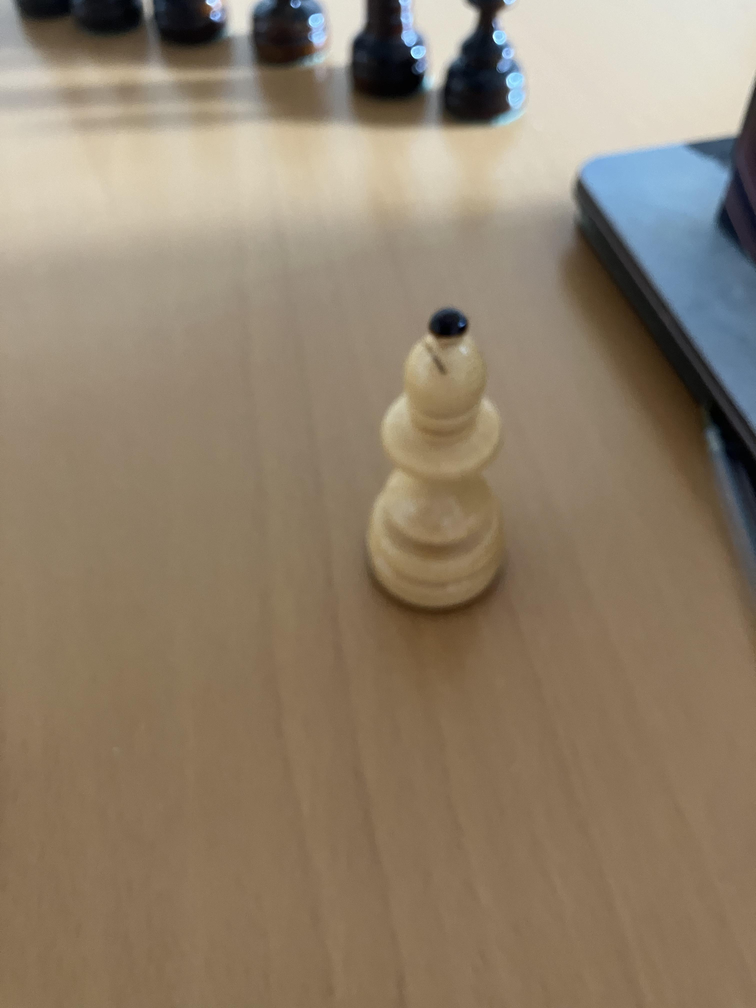

In [12]:
# show one of the images
train_dataset[10]["image"] 

# Evaluation before Training

In [13]:
import torch
from PIL import Image
from torchvision.transforms.functional import to_pil_image, resize

def run_model_evaluation(model, dataset, num_samples=None, device='cuda', constant_query=None):
    model.eval()
    results = []

    # Limit the dataset if a specific number of samples is provided
    if num_samples is not None:
        dataset = torch.utils.data.Subset(dataset, range(num_samples))

    for example in dataset:
        image = example["image"]
        if constant_query is None:
            query = example["query"]["en"]
        else:
            query = constant_query  # Use the constant query if provided

        # Display a reduced size version of the image
        pil_image = image
        aspect_ratio = pil_image.width / pil_image.height
        new_width = 300
        new_height = int(new_width / aspect_ratio)
        display_image = resize(pil_image, (new_height, new_width))
        display_image.show()  # This will open the image in the default image viewer

        # Construct the message template
        messages = [
            {
                "role": "user",
                "content": [
                    # {"type": "text", "text": "Answer briefly."},
                    {"type": "text", "text": query},
                    {"type": "image"}, # YOU CAN COMMENT THIS OUT IF THERE ARE NO IMAGES.
                    # {"type": "image"}, # ADD A SECOND IMAGE!!! Note that the text must be "image" for every image.
                ]
            }
        ]

        # actually prepare the text
        text = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
        print(f"Formatted text: {text}")

        inputs = processor(text=text, images=[image], return_tensors="pt", padding=True).to(device)
        # inputs = processor(text=text, images=[image1,image2], return_tensors="pt", padding=True).to(device) ## ADD A SECOND IMAGE!!!

        # Generate output from the model
        generated_ids = model.generate(**inputs, max_new_tokens=128)
        generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].shape[1]:], skip_special_tokens=True)

        # print(f"generated_texts: {generated_texts}\n")
        print(f"Prediction: {generated_texts[0]}\n")
        
        results.append(generated_texts[0])  # Store the result

    return results

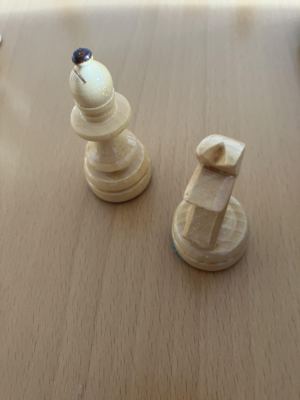

Formatted text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What kind of chess pieces do you see?<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

Prediction: The chess piece in the picture is a pawn. It has a round base with a slightly elongated top, which is characteristic of pawns in chess. The pawn on the right appears to be damaged or broken, as indicated by the missing piece at the top.



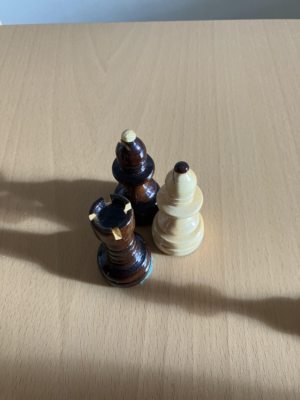

Formatted text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What kind of chess pieces do you see?<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

Prediction: The chess pieces in the picture are standard wooden pieces with a glossy finish. They appear to be from a set that includes both black and white pieces. The pieces have a distinctive shape, with the black pieces having a more elongated, cylindrical form and the white pieces having a more rounded, pyramid-like shape.



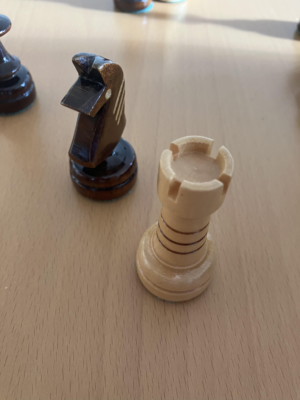

Formatted text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What kind of chess pieces do you see?<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

Prediction: The chess piece on the left is a black pawn, and the one on the right is a white queen. The queen has been broken off at the top, leaving only the base intact.



In [9]:
# Usage
eval_results = run_model_evaluation(model, eval_dataset, num_samples=3, device='cuda', constant_query="What kind of chess pieces do you see?")
# print(eval_results)

## Other Sample 
The example below shows how you can feed in zero, one or two images to the evaluation.

For no images, you can pass `images=None` into the processor. You can see how this is automatically handled below.

You can also train on multiple images using this approach, by adjusting the datacollator below in the same manner as is done for evaluation here. Note that you'll need to update your dataset so that it has a column for second (and subsequent images) and ensure they are passed correctly within the data collator.

In [26]:
image1 = "http://images.cocodataset.org/val2017/000000039769.jpg" # two cats
image2 = "http://images.cocodataset.org/val2017/000000219578.jpg" # dog and cat

# Choose between one of the following.
image_urls = [image1, image2]
# images = [image1]
# images = None

images = load_images(image_urls)

messages = []

# Add images
if images is not None:
    message_content = [{"type": "image"} for _ in images]
    message_content.append({"type": "text", "text": "How many images do you see and what is in each?"})
else:
    message_content = [{"type": "text", "text": "How are you today?"}]

# Add the composed message
messages.append({
    "role": "user",
    "content": message_content
})

print(messages)

# Or you can do this manually
# messages = [
#     {
#         "role": "user",
#         "content": [
#             {"type": "image"}, # ADD a first image
#             {"type": "image"}, # ADD A SECOND IMAGE!!! Note that the text must be "image" for every image.
#             {"type": "text", "text": "Say hello"}
#         ]
#     }
# ]

# Apply the chat template to preprocess input
text = processor.apply_chat_template(messages, add_generation_prompt=True)

print(f"formatted prompt: {text}")

inputs = processor(
    text=[text.strip()],
    images=images,
    return_tensors="pt",
    padding=True).to('cuda')

# Generate output from the model
generated_ids = model.generate(**inputs, max_new_tokens=64)
generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)

print(f"Prediction: {generated_texts[0]}\n")

[{'role': 'user', 'content': [{'type': 'image'}, {'type': 'image'}, {'type': 'text', 'text': 'How many images do you see and what is in each?'}]}]
formatted prompt: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|><|vision_start|><|image_pad|><|vision_end|>How many images do you see and what is in each?<|im_end|>
<|im_start|>assistant

Prediction: I see 2 images. And in the first image there is a cat and a dog on a couch. And in the second image there is a cat and a dog on a couch.(3,0),(999,999)



## Manual Evaluation on an image

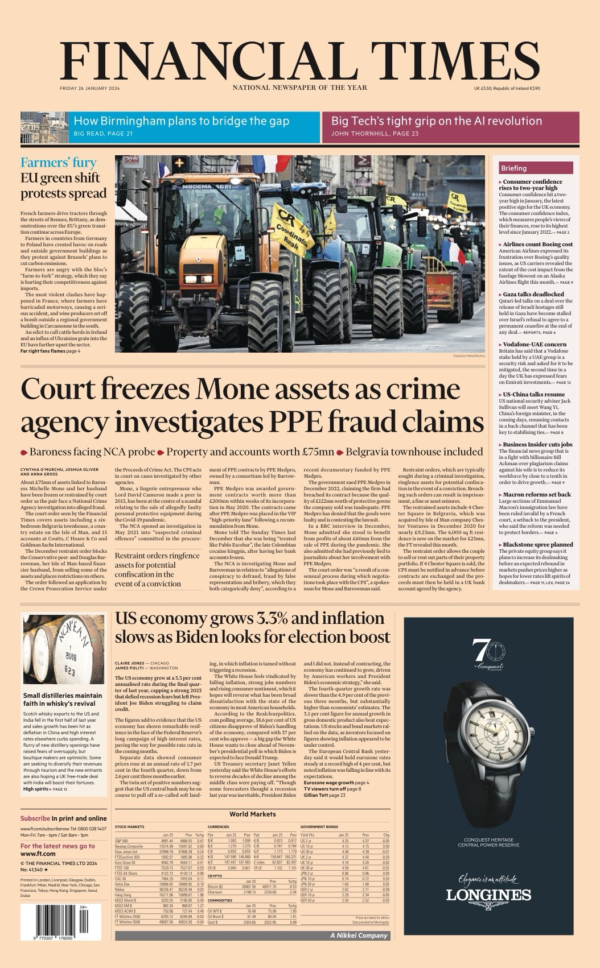

Prediction: Here are the headlines from the Financial Times:

1. **Farmers' fury**
   - EU green shift protests spread

2. **Court freezes Mone assets as crime agency investigates PPE fraud claims**

3. **US economy grows 3.3% and inflation slows as Biden looks for election boost**

4. **Small distilleries maintain faith in whisky's revival**

5. **Big Tech's tight grip on the AI revolution**

6. **Baroness facing NCA probe**


In [10]:
import torch
from PIL import Image
import requests
from torchvision.transforms.functional import to_pil_image, resize

def evaluate_image(image_url, model, processor, device='cuda'):
    model.eval()
    
    # Properly handle the image fetch and load
    response = requests.get(image_url, stream=True)  # Ensure the response is streamed
    response.raw.decode_content = True  # Decode the content that was streamed
    pil_image = Image.open(response.raw).convert('RGB')  # Now open it with PIL

    # Resize the image for display
    aspect_ratio = pil_image.width / pil_image.height
    new_width = 600
    new_height = int(new_width / aspect_ratio)
    display_image = resize(pil_image, (new_height, new_width))
    display_image.show()  # Display the image

    # Construct the message template
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"}, # YOU CAN COMMENT THIS OUT IF THERE ARE NO IMAGES.
                {"type": "text", "text": "What headlines do you see here?"}
            ]
        }
    ]

    # Apply the chat template to preprocess input
    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=text, images=[pil_image], return_tensors="pt", padding=True).to(device)

    # Generate output from the model
    generated_ids = model.generate(**inputs, max_new_tokens=512, temperature=0.3)
    generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)

    print(f"Prediction: {generated_texts[0]}")
    return generated_texts[0]

# Example usage
image_url = "https://www.tomorrowspapers.co.uk/wp-content/uploads/2024/01/Financial-Times-18.jpg"
result = evaluate_image(image_url, model, processor)

# Training loop

We first define the data collator which takes list of samples and return input tensors fed to the model. There are 4 tensors types we are interested:
- `input_ids`: these are the input indices fed to the language model
- `attention_mask`: the attention mask for the `input_ids` in the language model
- `pixel_values`: the (pre-processed) pixel values that encode the image(s). Idefics2 treats images in their native resolution (up to 980) and their native aspect ratio
- `pixel_attention_mask`: when multiple image(s) are packed into the same sample (or in the batch), attention masks for the images are necessary because of these images can have different sizes and aspect ratio. This masking ensures that the vision encoder properly forwards the images.


In [14]:
# # Compute loss over user and assistant responses - WARNING IF YOU HAVE SHORT ASSISTANT RESPONSES, THIS WILL LEAD TO POOR RESULTS.

# import random

# class MyDataCollator:
#     def __init__(self, processor):
#         self.processor = processor
#         # self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
#         #     processor.tokenizer.additional_special_tokens.index("<image>")
#         # ]

#     def __call__(self, examples):
#         texts = []
#         images = []
#         for example in examples:
#             image = example["image"]
#             question = 'What do you see here?' # for chess dataset
#             # question = example["query"]["en"] # for hf dataset
#             answer = example["caption"] # for chess dataset
#             # answer = random.choice(example["answers"]) # for hf dataset
#             messages = [
#                 {
#                     "role": "user",
#                     "content": [
#                         # {"type": "text", "text": "Answer briefly."},
#                         {"type": "text", "text": question},
#                         {"type": "image"}, # best to put the images after the text.
#                     ]
#                 },
#                 {
#                     "role": "assistant",
#                     "content": [
#                         {"type": "text", "text": answer}
#                     ]
#                 }
#             ]

#             # print("Before apply_chat_template:", messages)
#             text = processor.apply_chat_template(messages, add_generation_prompt=False,)
#             # print("After apply_chat_template:", text)
            
#             texts.append(text.strip())
#             images.append([image])

#         batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

#         labels = batch["input_ids"].clone()
#         # labels[labels == processor.tokenizer.pad_token_id] = self.image_token_id
#         batch["labels"] = labels

#         return batch

# data_collator = MyDataCollator(processor)

In [15]:
# ONLY COMPUTE THE LOSS OVER ASSISTANT RESPONSES.

import torch

class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, examples):
        texts = []
        images = []
        assistant_responses = []  # To track assistant responses for proper masking later
        for example in examples:
            image = example["image"]
            question = 'What do you see here?'  # for chess dataset
            answer = example["caption"]  # for chess dataset
            
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": question},
                        {"type": "image"},  # Images after the text.
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]

            # Convert messages to the desired text format using processor's template
            text = self.processor.apply_chat_template(messages, add_generation_prompt=False)

            texts.append(text.strip())
            images.append([image])
            assistant_responses.append(answer)  # Track assistant's response for later

        # Tokenize and process batch
        batch = self.processor(text=texts, images=images, return_tensors="pt", padding=True)

        # Prepare labels: we will mask non-assistant tokens for loss computation
        labels = batch["input_ids"].clone()

        # For each example, find assistant tokens and mask everything else
        for i, (input_ids, assistant_response) in enumerate(zip(batch["input_ids"], assistant_responses)):
            # Tokenize just the assistant response
            assistant_tokens = self.processor.tokenizer(assistant_response, return_tensors="pt")["input_ids"][0]

            # Find where the assistant tokens start in the input sequence
            # This method ensures we match the tokenized assistant response, not the raw text
            start_idx = self.find_subsequence(input_ids, assistant_tokens)

            if start_idx is not None:
                end_idx = start_idx + len(assistant_tokens)
            
                # Ensure EOS token remains unmasked
                if input_ids[end_idx] == processor.tokenizer.eos_token_id:
                    end_idx += 1
            
                # Mask non-assistant tokens
                labels[i, :start_idx] = -100  # Ignore tokens before the assistant's response
                labels[i, end_idx:] = -100  # Ignore tokens after the assistant's response (but keep EOS)

        # Assign masked labels back to the batch
        batch["labels"] = labels
        return batch

    def find_subsequence(self, sequence, subsequence):
        """Find the start index of a subsequence (assistant tokens) in a sequence (full tokenized input)"""
        seq_len = len(sequence)
        sub_len = len(subsequence)

        for i in range(seq_len - sub_len + 1):
            if torch.equal(sequence[i:i + sub_len], subsequence):
                return i
        return None

data_collator = MyDataCollator(processor)

In [16]:
#show a first example
print(train_dataset[0])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=756x1008 at 0x7904DD1F9930>, 'caption': 'A single white rook.'}


In [17]:
# Inspect Dataset

# Select a small batch of examples (e.g., 2 examples for quick testing)
sample_batch = [train_dataset[i] for i in range(2)]

# Call the data collator with the sample batch to process it
processed_batch = data_collator(sample_batch)
assistant_responses = [example["caption"] for example in sample_batch]  # Extract assistant responses manually

# Print the processed batch keys to check what's inside
print("Processed batch keys:", processed_batch.keys())

# Tokenized input IDs
input_ids = processed_batch["input_ids"]
labels = processed_batch["labels"]

# # Print tokenized input IDs
# print("\nTokenized input IDs:")
# print(input_ids)

# # Print labels (masked tokens)
# print("\nLabels (with masking applied):")
# print(labels)

# # Decode the tokenized inputs for human-readable format
# print("\nDecoded input texts:")
# for idx, input_id in enumerate(input_ids):
#     print(f"Example {idx}:")
#     print(processor.tokenizer.decode(input_id, skip_special_tokens=False))

# # Decode the labels to inspect which tokens are contributing to the loss
# print("\nDecoded labels (masking applied):")
# for idx, label in enumerate(labels):
#     # Decode the labels with masking handled
#     decoded_labels = processor.tokenizer.decode(
#         [token for token in label.tolist() if token != -100], skip_special_tokens=False
#     )
#     print(f"Example {idx}:")
#     print("Decoded:", decoded_labels)

# Sanity Check: Assistant Responses vs Decoded Labels
print("\nSanity Check: Assistant Responses vs Decoded Labels")
for idx, assistant_response in enumerate(assistant_responses):
    # Decode the labels again for comparison
    decoded_labels = processor.tokenizer.decode(
        [token for token in labels[idx].tolist() if token != -100], skip_special_tokens=True
    )
    print(f"Example {idx}:")
    print("Assistant Response:", assistant_response)
    print("Decoded Labels:", decoded_labels)
    print("Match:", assistant_response.strip() == decoded_labels.strip())

Processed batch keys: dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw', 'labels'])

Sanity Check: Assistant Responses vs Decoded Labels
Example 0:
Assistant Response: A single white rook.
Decoded Labels: A single white rook.
Match: True
Example 1:
Assistant Response: A white rook.
Decoded Labels: A white rook.
Match: True


In [18]:
print(processor.tokenizer.eos_token_id)

151645


In [19]:
# # SAMPLE CODE FOR HOW YOU MIGHT DO MULTIPLE IMAGES (OR NO IMAGES) - NOT TESTED WITH QWEN YET
# NOTE THAT THIS COMPUTES THE LOSS OVER USER *AND* ASSISTANT TOKENS, which is not ideal.
# import random

# class MyDataCollator:
#     def __init__(self, processor):
#         self.processor = processor
#         self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
#             processor.tokenizer.additional_special_tokens.index("<image>")
#         ]

#     def __call__(self, examples):
#         texts = []
#         images = []
#         for example in examples:
#             example_images = [example["image"]] #for just one image column in your dataset
#             # example_images =  [example["image1"], example["image2"]] # if you want two images
            
#             question = 'What do you see here?' # for chess dataset

#             answer = example["caption"] # for chess dataset

#             messages = []
            
#             # Add images
#             if example_images is not None:
#                 message_content = [{"type": "image"} for _ in example_images]
#                 message_content.append({"type": "text", "text": "How many images do you see and what is in each?"})
#             else:
#                 message_content = [{"type": "text", "text": "How are you today?"}]
            
#             # Add the composed message
#             messages.append({
#                 "role": "user",
#                 "content": message_content
#             })
#             text = processor.apply_chat_template(messages, add_generation_prompt=False)
#             texts.append(text.strip())
#             images.append(example_images)

#         batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

#         labels = batch["input_ids"].clone()
#         labels[labels == processor.tokenizer.pad_token_id] = self.image_token_id
#         batch["labels"] = labels

#         return batch

# data_collator = MyDataCollator(processor)

In [20]:
print(model)

Qwen2_5_VLForConditionalGeneration(
  (visual): Qwen2_5_VisionTransformerPretrainedModel(
    (patch_embed): Qwen2_5_VisionPatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2_5_VLVisionBlock(
        (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
        (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
        (attn): Qwen2_5_VLVisionFlashAttention2(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): Qwen2_5_VLMLP(
          (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
          (act_fn): SiLU()
        )
      )
    )
    (merger): Qwen2_5_VLPatchMerg

In [21]:
from peft import LoraConfig

lora_config = LoraConfig(
    r=32,                 # Rank (usually 8, 16, or 32 depending on model size and needs)
    lora_alpha=16,         # Scaling factor for the low-rank updates
    use_rslora=True,
    # target_modules="all-linear", # causes issues with Qwen
    target_modules=["q_proj","k_proj","v_proj","o_proj","up_proj","down_proj","gate_proj",
                    "mlp.0", "mlp.2",
                    # "fc1","fc2","qkv" # seems to cause oom easily.
                   ],
    modules_to_save=["lm_head","embed_tokens"], # may cause issues for qwen.
    lora_dropout=0.1,      # Dropout for low-rank adapter layers
    bias="none",           # Bias in adapter layers: "none", "all", or "lora_only"
    task_type="CAUSAL_LM"  # Task type: "CAUSAL_LM", "SEQ_2_SEQ_LM", or "TOKEN_CLS"
)

In [33]:
from peft import get_peft_model

model=get_peft_model(model,lora_config)

In [34]:
model.print_trainable_parameters()

trainable params: 74,862,592 || all params: 3,829,485,568 || trainable%: 1.9549


In [24]:
# # Move LoRA layers to the same dtype as the base model (UNCLEAR why some weights are cast to 32 bits)...
# for name, param in model.named_parameters():
#     if "lora" in name:  # Target LoRA parameters
#         param.data = param.data.to(dtype=torch.bfloat16)
#         if param.grad is not None:  # Move gradient if it exists
#             param.grad.data = param.grad.data.to(dtype=torch.bfloat16)

# # Verify all dtypes
# for name, param in model.named_parameters():
#     print(f"Layer: {name}, dtype: {param.dtype}")

In [25]:
# for name, param in model.named_parameters():
#     print(f"{name}: requires_grad={param.requires_grad}")

In [38]:
from transformers import TrainingArguments, Trainer

# for main fine-tuning
epochs=1
lr=3e-4 #3-e4 for 2B, 3e-5 for 7B, 3e-6 for 72B
schedule="constant"

# # Optional, for annealing
# epochs=1
# lr=3e-4
# schedule="linear"

run_name=f"trelis-chess-{lr}_lr-{epochs}_epochs-{schedule}_schedule-completions-only-annealing"

training_args = TrainingArguments(
    # max_steps=1,
    num_train_epochs=epochs,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    # warmup_steps=50, #comment in only if you have a lot more than 50 samples.
    learning_rate=lr,
    weight_decay=0.01,
    logging_steps=0.1,
    output_dir="fine-tuned-model",
    eval_strategy="steps",
    eval_steps=0.2,
    lr_scheduler_type=schedule,
    # save_strategy="steps",
    # save_steps=250,
    # save_total_limit=1,
    # fp16=True, #if using Colab, but then you need to use bitsandbytes quantization too.
    bf16=True,
    tf32=True,  # Use TensorFloat-32 precision. Only relevant if there are 32-bit weights.
    hub_model_id="Trelis/Qwen2.5-VLM-3B-chess",
    remove_unused_columns=False,
    report_to="tensorboard",
    run_name=run_name,
    logging_dir=f"./logs/{run_name}",
    gradient_checkpointing=True, #should reduce VRAM requirements a lot
    gradient_checkpointing_kwargs={'use_reentrant':True} # causes errors if not false with qwen
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset, # You can also evaluate (loss) on the eval set, note that it will incur some additional GPU memory
)

# TIP
# It can be nice to train with a constant learning rate, keep repeating that til the eval loss is flattening, then train for some steps with linear decay/annealing.

# Training and pushing to the hub

We have all the core building blocks now, so we fine-tune the model!

The training can take a few minutes depending on the hardware you use.

In [39]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss
3,0.972400,1.426098
6,0.772800,1.582754
9,0.709300,1.503630
12,0.656200,1.285040


TrainOutput(global_step=12, training_loss=0.7595227062702179, metrics={'train_runtime': 47.1865, 'train_samples_per_second': 1.017, 'train_steps_per_second': 0.254, 'total_flos': 1022733590200320.0, 'train_loss': 0.7595227062702179, 'epoch': 1.0})

# Evaluation

Let's evaluate the model. First, we can have a look at a qualitative generation from the model.

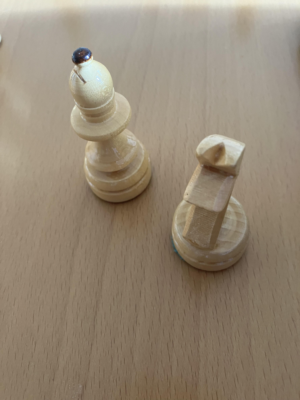

Formatted text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What do you see here?<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

Prediction: A white bishop beside a white knight.



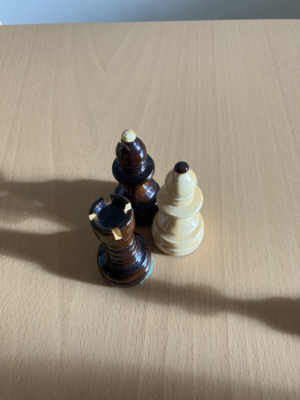

Formatted text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What do you see here?<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

Prediction: A black queen beside a white bishop and a black rook, all viewed from the top.



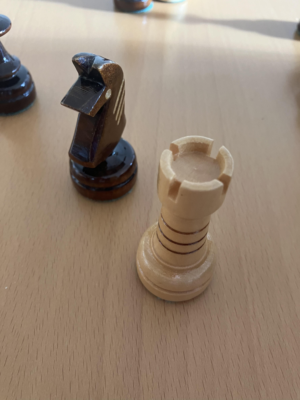

Formatted text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What do you see here?<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

Prediction: A black knight beside a white king.



In [40]:
eval_results = run_model_evaluation(model, eval_dataset, num_samples=3, device='cuda', 
                                    constant_query="What do you see here?"
                                    # constant_query="Que voyez vous ici?"
                                   )

In [ ]:
stop here before pushing to hub.

# Push to Hub

In [ ]:
# # Will only push lora adapters
# trainer.push_to_hub()

In [30]:
# Merge the model
model = model.merge_and_unload()

In [24]:
# Technically, if you want the best performance, you should save and push your lora adapters, reload the base model, then dequantize that base model, then reload the adapter on top of that, then merge...
# model = model.dequantize() # may be a useful command here.

The model is going to be dequantized in torch.bfloat16 - if you want to upcast it to another dtype, make sure to pass the desired dtype when quantizing the model through `bnb_4bit_quant_type` argument of `BitsAndBytesConfig`


In [32]:
model.push_to_hub("Trelis/chess_qwen_vl_2b_vision")

model-00002-of-00006.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.26G [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Trelis/chess_pixtral/commit/7c1b2e114029bf0d3f85c9c8b24b92cf448d1e51', commit_message='Upload LlavaForConditionalGeneration', commit_description='', oid='7c1b2e114029bf0d3f85c9c8b24b92cf448d1e51', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Trelis/chess_pixtral', endpoint='https://huggingface.co', repo_type='model', repo_id='Trelis/chess_pixtral'), pr_revision=None, pr_num=None)

# OCR Type evaluation (Optical Character Recognition)

Only run this if your dataset contains text. If it doesn't then there is no text to check!

During the training, we tracked the loss on the evaluation split. It is interesting to measure the performance using the "true metric" used for DocVQA.

The metric at hand is the *Average Normalized Levenshtein Similarity* (ANLS). The Average Normalized Levenshtein Similarity (ANLS) proposed by [Biten+ ICCV'19](https://arxiv.org/abs/1905.13648) smoothly captures the OCR mistakes applying a slight penalization in case of correct intended responses, but badly recognized. It also makes use of a threshold of value 0.5 that dictates whether the output of the metric will be the ANLS if its value is equal or bigger than 0.5 or 0 otherwise. The key point of this threshold is to determine if the answer has been correctly selected but not properly recognized, or on the contrary, the output is a wrong text selected from the options and given as an answer.

We first define a few utilities to compute the ANLS.

In [26]:
!pip install Levenshtein -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [27]:
import Levenshtein

def normalized_levenshtein(s1, s2):
    len_s1, len_s2 = len(s1), len(s2)
    distance = Levenshtein.distance(s1, s2)
    return distance / max(len_s1, len_s2)

def similarity_score(a_ij, o_q_i, tau=0.5):
    nl = normalized_levenshtein(a_ij, o_q_i)
    return 1 - nl if nl < tau else 0

def average_normalized_levenshtein_similarity(ground_truth, predicted_answers):
    assert len(ground_truth) == len(predicted_answers), "Length of ground_truth and predicted_answers must match."

    N = len(ground_truth)
    total_score = 0

    for i in range(N):
        a_i = ground_truth[i]
        o_q_i = predicted_answers[i]
        if o_q_i == "":
            print("Warning: Skipped an empty prediction.")
            max_score = 0
        else:
            max_score = max(similarity_score(a_ij, o_q_i) for a_ij in a_i)

        total_score += max_score

    return total_score / N


In [28]:
# Some gpu mem cleaning before inferencing eval. necessary because we are in memory constrained env
torch.cuda.empty_cache()


In [32]:
from tqdm import tqdm

answers_unique = []
generated_texts_unique = []

EVAL_BATCH_SIZE = 1

for i in tqdm(range(0, len(eval_dataset), EVAL_BATCH_SIZE)):
    examples = eval_dataset[i: i + EVAL_BATCH_SIZE]
    # answers_unique.extend(examples["answers"])
    answers_unique.extend(examples["caption"])
    images = [[im] for im in examples["image"]]
    texts = []
    # for q in examples["query"]:
    #     messages = [
    #         {
    #             "role": "user",
    #             "content": [
    #                 # {"type": "text", "text": "Answer briefly."},
    #                 {"type": "image"},
    #                 # {"type": "text", "text": q["en"]}
    #                 {"type": "text", "text": q}
    #             ]
    #         }
    #     ]
    #     text = processor.apply_chat_template(messages, add_generation_prompt=True)
    #     texts.append(text.strip())

    hardcoded_query = "What do you see here?"

    messages = [
        {
            "role": "user",
            "content": [
                # {"type": "text", "text": "Answer briefly."},
                {"type": "text", "text": hardcoded_query},
                {"type": "image"},
            ]
        }
    ]
    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    texts.append(text.strip())
    
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True).to('cuda')
    generated_ids = model.generate(**inputs, max_new_tokens=64)
    generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)
    generated_texts_unique.extend(generated_texts)

    print(generated_texts)


 33%|███▎      | 1/3 [00:02<00:05,  2.69s/it]

['A white chess piece, namely, a rook.']


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
 67%|██████▋   | 2/3 [00:05<00:02,  2.79s/it]

['A black rook, a black knight and a white pawn.']


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
100%|██████████| 3/3 [00:09<00:00,  3.09s/it]

['A white rook. A black knight. And part of a white pawn. All on a white chess board.']


In [33]:
generated_texts_unique = [g.strip().strip(".") for g in generated_texts_unique]
anls = average_normalized_levenshtein_similarity(
    ground_truth=answers_unique, predicted_answers=generated_texts_unique,
)
print(anls)

0.0
